![swung logo](../images/swung_logo_vector.png)
# Transform 21: Practical Seismic in Python #
# Graeme Mackenzie & Jørgen Kvalsvik (Equinor) #

## Introduction

During this tutorial we are going to demonstrate how to read in a 4D base and monitor volumes using 2 different python packages, plot some lines and slices interactively then calculate some simple 4D attributes (4D difference and NRMS) and apply a frequency filter to the data.

### Requirements

#### Python Packages

In addition to the standard packages we will need
 - segyio
 - seismic-zfp
 - scipy
 - pyviz
 - holoviz
 
If you are using Anaconda these can be installed using:

    conda install -c segyio scipy pyviz holoviz
    pip install seismic-zfp
 
If you are using python for windows these will all need to be installed through pip install. However it is much easier to install holoviz using Anaconda (if you are using pip you will likely need to download and install the individual whl files)

#### Data

We are going to use 2 volumes from the Volve data which has been published by Equinor.  You can read about it [here](https://www.equinor.com/en/news/14jun2018-disclosing-volve-data.html) and download the data [here](https://data.equinor.com/dataset/Volve)

We will use data from the 4D processing of the ST0202 and ST10010 surveys which are in the ST0202vsST10010_4D sub directory

- ST0202ZDC12-PZ-PSDM-KIRCH-FULL-T.MIG_FIN.POST_STACK.3D.JS-017534.segy
- ST10010ZDC12-PZ-PSDM-KIRCH-FULL-T.MIG_FIN.POST_STACK.3D.JS-017534.segy


We can also download the SEG-Ys using the azure cli and the code in the cells below

In [ ]:
# to download the SEG-Ys from volve we use the azure cli
import sys
!{sys.executable} -m pip install azure-cli

In [ ]:
import sys
import os

# The shared access signature URI can be found on the Volve download page. The token is the stuff after ?, should be sv=<date>&sr=<sr>...
sastoken = '<sas-token-here>'
if not os.path.exists('../data/ST10010.segy'):
    !{sys.executable} -m azure.cli storage blob download \
        --account-name datavillagesa \
        --container-name volve \
        --name "Seismic/ST0202vsST10010_4D/Stacks/ST10010ZDC12-PZ-PSDM-KIRCH-FULL-T.MIG_FIN.POST_STACK.3D.JS-017534.segy" \
        --file "../data/ST10010.segy" \
        --sas-token "{sastoken}"

if not os.path.exists('../data/ST0202.segy'):
    !{sys.executable} -m azure.cli storage blob download \
        --account-name datavillagesa \
        --container-name volve \
        --name "Seismic/ST0202vsST10010_4D/Stacks/ST0202ZDC12-PZ-PSDM-KIRCH-FULL-T.MIG_FIN.POST_STACK.3D.JS-017534.segy" \
        --file "../data/ST0202.segy" \
        --sas-token "{sastoken}"

In [ ]:
def cleanup():
    """
    Run this to have the notebook clean up after itself. It is not run automatically.
    """
    import os
    os.remove('../data/ST0202.segy')
    os.remove('../data/ST10010.segy')

## Basic Imports

We'll start with importing some packages; <br>
- NumPy and Xarray (which we will use to hold the data once we have read it in)
- Segyio and seismic-zfp (to read the data)
- Scipy to run some signal processing
- matlotlib, hvplot and panels for visualizing the data 
- time just so we can get some statistics on how long things take to run

***Do we need pandas?  (possible if we are reading the headers)***

In [5]:
import numpy as np
import xarray as xr
import segyio
import seismic_zfp
from seismic_zfp.conversion import SegyConverter, SgzReader
from scipy import signal
import matplotlib
import matplotlib.pyplot as plt
import hvplot.xarray
import panel as pn
import time

## Reading the Volve 2002 base survey using segyio

We will read the base 2002 survey using segyio


Jørgen to add

Get some info about our data
- Read the headers?
- Plot the x,y locations of the survey?
- .....

In [6]:
base_segy = '../data/ST0202.segy'
matplotlib.rcParams['figure.figsize'] = (11.75, 8.5)

Try to read the file

In [7]:
with segyio.open(base_segy) as segyf:
    n_traces = segyf.tracecount
    sample_rate = segyio.tools.dt(segyf)/1000
    n_samples = segyf.samples.size
    n_il = len(segyf.iline)

ValueError: Inlines inconsistent, expect all inlines to be unique

Highlight problem is that the segy is not a perfect cube (number of inlines * number of xlines = number of traces).<br>
There are a number of possible solutions to this. Here use the solution given in one of the segyio example notebooks
https://github.com/equinor/segyio-notebooks/blob/master/notebooks/pylops/01_seismic_inversion.ipynb

***Need to check/change the naming of the variables since we will be reading 2 volumes***

In [15]:
f = segyio.open(base_segy, ignore_geometry = True)
ntraces    = len(f.trace)
inlines    = []
crosslines = []

for i in range(ntraces):
    headeri = f.header[i]
    inlines.append(headeri[segyio.su.iline])
    crosslines.append(headeri[segyio.su.xline])

print(f'{ntraces} traces')
print(f'first 10 inlines: {inlines[:10]}')
print(f'first 10 crosslines: {crosslines[:10]}')

256614 traces
first 10 inlines: [9961, 9961, 9961, 9961, 9961, 9961, 9961, 9961, 9961, 9961]
first 10 crosslines: [1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972]


Ok, so we have the inlines and crosslines. It's not a perfect cube, so time to verify that and figure out which in/crossline pairs that are missing.

In [56]:
import itertools
uniqil = set(inlines)
uniqxl = set(crosslines)
real = set(zip(inlines, crosslines))
grid = set(itertools.product(uniqil, uniqxl))
missing = grid - real
missing

{(9961, 1961),
 (9961, 1962),
 (9961, 2598),
 (9961, 2600),
 (9962, 1961),
 (9962, 1962),
 (9962, 2598),
 (9962, 2600),
 (10273, 1961),
 (10274, 1961),
 (10331, 1961),
 (10332, 1961),
 (10335, 1961),
 (10336, 1961),
 (10339, 1961),
 (10340, 1961),
 (10343, 1961),
 (10344, 1961),
 (10347, 1961),
 (10348, 1961),
 (10351, 1961),
 (10352, 1961),
 (10355, 1961),
 (10356, 1961),
 (10359, 1961),
 (10360, 1961)}

In [7]:
# Read all the traces then reshape in numpy
t0 = time.time()
f = segyio.open(base_segy, ignore_geometry=True)
traces = segyio.collect(f.trace)[:]
ntraces, nt = traces.shape

t = f.samples[:]
il = f.attributes(segyio.TraceField.INLINE_3D)[:]
xl = f.attributes(segyio.TraceField.CROSSLINE_3D)[:]

## Define regular IL and XL axes

il_unique = np.unique(il)
xl_unique = np.unique(xl)

il_min, il_max = min(il_unique), max(il_unique)
xl_min, xl_max = min(xl_unique), max(xl_unique)

# Get line increment
dt = t[1] - t[0]
dil = min(np.unique(np.diff(il_unique)))
dxl = min(np.unique(np.diff(xl_unique)))

# Create grid and get number of inlines & xlines
ilines = np.arange(il_min, il_max + dil, dil)
xlines = np.arange(xl_min, xl_max + dxl, dxl)
nil, nxl = ilines.size, xlines.size

ilgrid, xlgrid = np.meshgrid(np.arange(nil),
                             np.arange(nxl),
                             indexing='ij')

# Look-up table
traces_indeces = np.full((nil, nxl), np.nan)
iils = (il - il_min) // dil
ixls = (xl - xl_min) // dxl
traces_indeces[iils, ixls] = np.arange(ntraces)
traces_available = np.logical_not(np.isnan(traces_indeces))

# Reorganize traces in regular grid
d = np.zeros((nil, nxl, nt))
d[ilgrid.ravel()[traces_available.ravel()],
  xlgrid.ravel()[traces_available.ravel()]] = traces
# Return the time (in seconds to do this)
sgy_r_time = time.time() - t0
print(f'segy file with {ntraces} traces ({nil} inlines, {nxl} xlines) indexed and read in {sgy_r_time} s')

segy file with 256614 traces (401 inlines, 640 xlines) indexed and read in 6.599068641662598 s


Explain the outputs <br>
Data is in a 3D numpy array and our inline, crossline and twt are also in separate numpy arrays

In [9]:
d.shape

(401, 640, 850)

In [10]:
ilines.shape

(401,)

In [11]:
ilines

array([ 9961,  9962,  9963,  9964,  9965,  9966,  9967,  9968,  9969,
        9970,  9971,  9972,  9973,  9974,  9975,  9976,  9977,  9978,
        9979,  9980,  9981,  9982,  9983,  9984,  9985,  9986,  9987,
        9988,  9989,  9990,  9991,  9992,  9993,  9994,  9995,  9996,
        9997,  9998,  9999, 10000, 10001, 10002, 10003, 10004, 10005,
       10006, 10007, 10008, 10009, 10010, 10011, 10012, 10013, 10014,
       10015, 10016, 10017, 10018, 10019, 10020, 10021, 10022, 10023,
       10024, 10025, 10026, 10027, 10028, 10029, 10030, 10031, 10032,
       10033, 10034, 10035, 10036, 10037, 10038, 10039, 10040, 10041,
       10042, 10043, 10044, 10045, 10046, 10047, 10048, 10049, 10050,
       10051, 10052, 10053, 10054, 10055, 10056, 10057, 10058, 10059,
       10060, 10061, 10062, 10063, 10064, 10065, 10066, 10067, 10068,
       10069, 10070, 10071, 10072, 10073, 10074, 10075, 10076, 10077,
       10078, 10079, 10080, 10081, 10082, 10083, 10084, 10085, 10086,
       10087, 10088,

## Plotting the data
As geophysicists one of the first things we want to do once we've loaded some data is to view it. We're going to use matplotlib to vizualize a single (central) inline

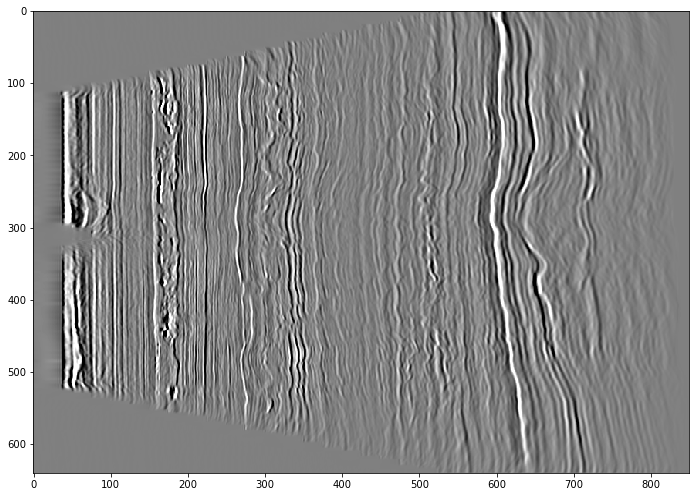

In [8]:
# Plot
imgplot = plt.imshow(d[nil//2,:,:], cmap='gray', aspect='auto', vmin=-5, vmax=5)

We can see that it's definitely seismic but not oriented how we would expect.  Also the axis labels aren't really meaningful to us. <br>
When using any plotting packages in Python we need to consider the origin and how the data is read.  Matplotlib assumes the origin is in the top right corner (which is fine for a section but possibly not what we would want if plotting a time slice) but we need to transpose the array so it plots with the time on the y-axis <br>
We also need to read the arrays containing the travel time and xline numbers and add these to the plot as labels.

In [ ]:
# Define the plot larger
fig, ax = plt.subplots(figsize=(10, 6))
# Include the extent from the relevant arrays containing the time and xline
extent = [xlines[0],xlines[-1],t[-1],t[0]]
# Plot the central inline in the usual orientation by transposing the data
imgplot = ax.imshow(d[nil//2,:,:].T, cmap='gray', aspect='auto', vmin=-5, vmax=5, extent=extent)
# Add some labels
ax.set_xlabel('Xline')
ax.set_ylabel('TWT (ms)')

Note that whilst matplotlib has the origin for the plot at the top right, the extent is coded as (left, right, bottom, top)
(see [here](https://matplotlib.org/stable/tutorials/intermediate/imshow_extent.html) for more details on origins and extents in matplotlib.)

We can also plot a slice, in this case we don't need transpose the data, but we have changed the origin to the bottom left

In [ ]:
# T-Slice
extent = [xlines[0],xlines[-1],ilines[-1],ilines[0]]
#imgplot = plt.imshow(d[:,:,575], cmap='gray', origin='lower', aspect='auto', vmin=-5, vmax=5)
imgplot = plt.imshow(d[:,:,75], cmap='gray', origin='lower', aspect='auto', vmin=-5, vmax=5, extent=extent)

### Interactive plotting

Ideally we would like to be quickly scan through some lines, rather than having to edit the index number of the data and rerun the cell above multiple times. <br>

We're going to use the advance plotting options of hvplot and panel to create an interactive plot

In [ ]:
# Define a plotting function, the input will be an array containing the inlines

def plot_inl(inl):
    idx = inl - ilines[0]
    da = xr.DataArray(d[idx,:,:].T)    
    p = da.hvplot.image(clim=(-5, 5), cmap='gray', flip_yaxis=True) 
    return p

In [ ]:
il_slice = pn.interact(plot_inl, inl=ilines)
il_slice

## Using Xarray

As with our original plot using matplotlib the interactive plot above has no useful axis info. <br>
In the *plot_inl* function we had to convert our numpy array into an DataArray in order to allow us to plot it with hvplot.  However, Xarray has a lot more useful functionality that makes it ideal for using with seismic data.  Xarray simplifies working with multi-dimensional data and allows dimension, coordinate and attribute labels to be added (segysak utilises it and Tony's tutorial on Tuesday provided some more information on the format).<br>
Xarray has two data structures
- DataArray: for a single data variable
- DataSet: a container for multiple Data Arrays that share the same coordinates

The figure below [(Hoyer & Hamman, 2017)](https://openresearchsoftware.metajnl.com/articles/10.5334/jors.148/) illustrates the concept of a dataset containing climate data
![xarray example](../images/xarray.png)

In [9]:
#Create a Data Array
da = xr.DataArray(data=d,
                  dims=['il','xl','twt'],
                  coords={'il': ilines,
                          'xl': xlines,
                          'twt': t})

In [10]:
# Take a look
da

<xarray.DataArray (il: 401, xl: 640, twt: 850)>
array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-7.98719725e-07, -1.29252662e-08, -4.26842576e-07, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-1.11241752e-06,  1.77797439e-08, -5.20629499e-07, ...,
          4.05883417e-03,  6.52093813e-03,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-1.31961133e-06,  2.79510743e-07, -5.98793861e-07, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-1.56018450e-06,  1.39191002e-07, -6.82258303e-07, ...,
          2.96148402e-03,  1.00382045e-02,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[-1.35172468e-06, -6.46603553e-08, -6.46742308e-07, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-1.60073432e-06,  2.58957300e-08, -7.63166156e-07, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-1.61038133e-06,  3.62216213e-07, -6.46784088e-07, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [-1.94025961e-06,  2.39289648e-07, -7.08187315e-07, ...,
          7.62753934e-03,  1.08539276e-02,  0.00000000e+00],
        [-1.97906502e-06,  2.24742848e-07, -7.85791713e-07, ...,
          6.99467584e-03,  1.01896785e-02,  0.00000000e+00],
        [-1.54572717e-06,  1.27735177e-07, -6.61307240e-07, ...,
          5.26840240e-03,  7.51767680e-03,  0.00000000e+00]],

       ...,

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-1.05469180e-05,  7.42146312e-06, -1.57810518e-06, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-1.12935277e-05,  7.84187341e-06, -1.55217549e-06, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [-7.52819051e-06, -3.84819543e-07, -3.36958328e-06, ...,
          9.18272510e-03,  9.24098864e-03,  0.00000000e+00],
        [-4.80859853e-06, -1.17710169e-06, -2.48998185e-06, ...,
          9.65326652e-03,  1.05338320e-02,  0.00000000e+00],
        [-2.92655113e-06, -9.37797722e-07, -1.62011838e-06, ...,
          7.39553943e-03,  8.42276216e-03,  0.00000000e+00]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-9.51063339e-06,  6.58284807e-06, -2.00849809e-06, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-1.00548414e-05,  7.35734466e-06, -1.73596891e-06, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [-6.65727475e-06, -1.37618656e-07, -3.04394052e-06, ...,
          8.32594559e-03,  7.72155449e-03,  0.00000000e+00],
        [-4.04515322e-06, -9.60539182e-07, -2.15087857e-06, ...,
          8.75570625e-03,  8.88131931e-03,  0.00000000e+00],
        [-2.39406381e-06, -8.05759782e-07, -1.34904531e-06, ...,
          6.95621222e-03,  7.19533488e-03,  0.00000000e+00]],

       [[-3.77703509e-06,  3.14322006e-06, -3.29862758e-07, ...,
          0.0000000

We now have our inline, crossline and travel time held as coordinates within inside the same array as the data itself. <br>  This allows us to select data either using the standard numpy numerical indexing and slicing or using xarray's .sel label based indexing, allowing us to select data based on the coordinate. <br> 

In [42]:
da.sel(twt=3000)

<xarray.DataArray (il: 401, xl: 640)>
array([[ 0.        ,  0.        , -0.44658303, ...,  0.        ,
         0.2557013 ,  0.        ],
       [ 0.        ,  0.        , -0.55031383, ...,  0.        ,
         0.38241923,  0.        ],
       [-0.37162042, -0.55971771, -0.64201736, ...,  0.5276894 ,
         0.52819502,  0.3960734 ],
       ...,
       [ 0.        ,  0.23780131,  0.29040313, ..., -0.79084879,
        -0.72455043, -0.53777945],
       [ 0.        ,  0.2108404 ,  0.23452151, ..., -0.63714844,
        -0.57449812, -0.41911721],
       [ 0.0875504 ,  0.15109938,  0.16316354, ..., -0.47921669,
        -0.41603863, -0.29813576]])
Coordinates:
  * il       (il) int32 9961 9962 9963 9964 9965 ... 10358 10359 10360 10361
  * xl       (xl) int32 1961 1962 1963 1964 1965 ... 2596 2597 2598 2599 2600
    twt      float64 3e+03
Attributes:
    Year:     2002
    Type:     PSDM time converted

In [43]:
da[:,:,749]

<xarray.DataArray (il: 401, xl: 640)>
array([[ 0.        ,  0.        , -0.44658303, ...,  0.        ,
         0.2557013 ,  0.        ],
       [ 0.        ,  0.        , -0.55031383, ...,  0.        ,
         0.38241923,  0.        ],
       [-0.37162042, -0.55971771, -0.64201736, ...,  0.5276894 ,
         0.52819502,  0.3960734 ],
       ...,
       [ 0.        ,  0.23780131,  0.29040313, ..., -0.79084879,
        -0.72455043, -0.53777945],
       [ 0.        ,  0.2108404 ,  0.23452151, ..., -0.63714844,
        -0.57449812, -0.41911721],
       [ 0.0875504 ,  0.15109938,  0.16316354, ..., -0.47921669,
        -0.41603863, -0.29813576]])
Coordinates:
  * il       (il) int32 9961 9962 9963 9964 9965 ... 10358 10359 10360 10361
  * xl       (xl) int32 1961 1962 1963 1964 1965 ... 2596 2597 2598 2599 2600
    twt      float64 3e+03
Attributes:
    Year:     2002
    Type:     PSDM time converted

In [44]:
# To select a range we use slice
da.sel(twt=slice(2000,3000))

<xarray.DataArray (il: 401, xl: 640, twt: 251)>
array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 1.35877490e-04,  9.42404731e-05, -1.32005458e-04, ...,
         -4.11771417e-01, -5.02731919e-01, -4.46583033e-01],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 5.00009861e-04,  5.95724210e-04,  1.19948061e-03, ...,
          4.75020528e-01,  4.96732295e-01,  2.55701303e-01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 3.72831011e-04, -7.69765757e-05, -5.12102153e-04, ...,
         -4.78252828e-01, -6.15918279e-01, -5.50313830e-01],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 9.55314841e-04,  1.22649036e-03,  2.05514766e-03, ...,
          6.05619729e-01,  6.53584838e-01,  3.82419229e-01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[-1.87011028e-05, -1.18135722e-04, -4.65840334e-04, ...,
         -4.03343499e-01, -4.26371336e-01, -3.71620417e-01],
        [ 7.22661352e-05, -6.56024349e-05, -5.73838595e-04, ...,
         -5.48217356e-01, -6.24427676e-01, -5.59717715e-01],
        [ 5.36462525e-04,  3.06336675e-04, -3.18278326e-04, ...,
         -5.78300953e-01, -7.01441646e-01, -6.42017365e-01],
        ...,
        [ 1.76892895e-03,  2.21911957e-03,  3.99252027e-03, ...,
          7.24589348e-01,  7.97647059e-01,  5.27689397e-01],
        [ 1.37805496e-03,  1.68063003e-03,  2.66576000e-03, ...,
          7.39490271e-01,  8.09076369e-01,  5.28195024e-01],
        [ 5.43540809e-04,  6.90797344e-04,  1.11140986e-03, ...,
          5.80961764e-01,  6.25429034e-01,  3.96073401e-01]],

       ...,

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-5.42070484e-04, -3.91676556e-04, -2.02500523e-04, ...,
          8.77051950e-02,  1.59998715e-01,  2.37801313e-01],
        [-1.52215711e-04,  5.85389324e-04,  1.51147158e-03, ...,
          1.24817908e-01,  1.54764295e-01,  2.90403128e-01],
        ...,
        [-1.59651274e-03, -2.18816241e-03, -3.01230233e-03, ...,
         -7.61887431e-01, -9.58343804e-01, -7.90848792e-01],
        [-2.10060854e-04, -4.61495714e-04, -6.99896598e-04, ...,
         -6.65918052e-01, -8.73018503e-01, -7.24550426e-01],
        [ 4.24758182e-05, -2.87550647e-05, -1.70354819e-04, ...,
         -4.88200903e-01, -6.57923520e-01, -5.37779450e-01]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-3.90910544e-04, -4.51400876e-04, -2.83891102e-04, ...,
          3.30060534e-02,  1.75310612e-01,  2.10840404e-01],
        [ 5.99419436e-05,  3.35680088e-04,  9.97898169e-04, ...,
          6.73872828e-02,  1.51542425e-01,  2.34521508e-01],
        ...,
        [-1.25148008e-03, -1.59146381e-03, -2.45289528e-03, ...,
         -7.03456283e-01, -8.32394958e-01, -6.37148440e-01],
        [-8.50293191e-07, -1.23717648e-04, -4.01479891e-04, ...,
         -6.16141498e-01, -7.58824527e-01, -5.74498117e-01],
        [ 4.29477514e-05, -1.98534544e-05, -1.76283807e-04, ...,
         -4.51510787e-01, -5.69454253e-01, -4.19117212e-01]],

       [[-2.91780103e-04, -2.98212981e-04, -3.26096080e-04, ...,
          1.0492105

We've converted the 2002 seismic into a DataArray, but as we're going to be reading another vintage, it's useful to convert it into a DataSet which we can add the 2010 monitor survey into. <br> 
We'll also add some attribute information both to the data array and the dataset

In [11]:
# Add some attribute information to the datarray
da.attrs['Year'] = '2002'
da.attrs['Type'] = 'PSDM time converted'
# Create a dataset
volve_ds = da.to_dataset(name='base')
# Add some attribute information to the dataset
volve_ds.attrs['Country'] = 'Norway'
volve_ds.attrs['Field'] = 'Volve'
# Take a look
volve_ds

<xarray.Dataset>
Dimensions:  (il: 401, twt: 850, xl: 640)
Coordinates:
  * il       (il) int32 9961 9962 9963 9964 9965 ... 10358 10359 10360 10361
  * xl       (xl) int32 1961 1962 1963 1964 1965 ... 2596 2597 2598 2599 2600
  * twt      (twt) float64 4.0 8.0 12.0 16.0 ... 3.392e+03 3.396e+03 3.4e+03
Data variables:
    base     (il, xl, twt) float64 0.0 0.0 0.0 0.0 ... 0.006053 0.006397 0.0
Attributes:
    Country:  Norway
    Field:    Volve

Getting data from the xarray dataset is similar to a dictionary key and value

In [45]:
# Extract a line from the base survey
volve_ds['base'].sel(il=9963)

<xarray.DataArray 'base' (xl: 640, twt: 850)>
array([[-1.35172468e-06, -6.46603553e-08, -6.46742308e-07, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.60073432e-06,  2.58957300e-08, -7.63166156e-07, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.61038133e-06,  3.62216213e-07, -6.46784088e-07, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-1.94025961e-06,  2.39289648e-07, -7.08187315e-07, ...,
         7.62753934e-03,  1.08539276e-02,  0.00000000e+00],
       [-1.97906502e-06,  2.24742848e-07, -7.85791713e-07, ...,
         6.99467584e-03,  1.01896785e-02,  0.00000000e+00],
       [-1.54572717e-06,  1.27735177e-07, -6.61307240e-07, ...,
         5.26840240e-03,  7.51767680e-03,  0.00000000e+00]])
Coordinates:
    il       int32 9963
  * xl       (xl) int32 1961 1962 1963 1964 1965 ... 2596 2597 2598 2599 2600
  * twt      (twt) float64 4.0 8.0 12.0 16.0 ... 3.392e+03 3.396e+03 3.4e+03
Attributes:
    Year:     2002
    Type:     PSDM time converted

# 5 - 10 MIN BREAK ?

## Reading the Volve 2010 monitor survey using seismic-zfp

Now we've read and reviewed one vintage, let's read the second

Another option to get around the irregular geometry would be to use segysak (ref Tony's tutorial).  Here we'll use a third option and convert the segy file into another format that automatically pads the data.  We will use seismic-zfp which forms a compressed format.  We won't go into detail on this format but more information can be found .... (add links)

### Conversion from segy to seismic-zfp format

First step is to convert the file

In [12]:
monitor_segy = '../data/ST10010.segy'
monitor_sgz = '../data/ST10010.sgz'

In [77]:
sgz_t0 = time.time()
with SegyConverter(monitor_segy) as converter:
    # Create a "standard" SGZ file with 8:1 compression, using in-memory method
    converter.run(monitor_sgz, bits_per_voxel=4)
sgz_elapse = time.time() - sgz_t0
print(f'Converted to sgz in {sgz_elapse} s')

Converting: In=../data/ST10010.segy, Out=../data/ST10010.sgz
SEG-Y file is unstructured and no geometry provided. Determining this may take some time...
... inferred geometry is: IL:[9961,10361,1] -- XL:[1961,2600,1]
VirtualMemory=32612.328125MB, InlineSet=8.30078125MB : Using queue of length 16
Total conversion time: 12.276822566986084                     
Converted to sgz in 12.277821779251099 s


### Read seismic-zfp
Now it's converted we can read it

In [13]:
# Read the cube from zgy
t0 = time.time()
with SgzReader(monitor_sgz) as reader:
    n_traces_m = reader.tracecount
    n_il_m = reader.n_ilines
    n_xl_m = reader.n_xlines
    num_samples_m = reader.n_samples
    ilines_m = reader.ilines
    xlines_m = reader.xlines
    data_m = reader.read_volume()
zgy_r_time = time.time() - t0
print(f'sgz file with {n_traces_m} traces ({n_il_m} inlines, {n_xl_m} xlines) read in {zgy_r_time} s')

sgz file with 256640 traces (401 inlines, 640 xlines) read in 2.4731431007385254 s


You'll notice that reading the sgz file took much less time than segyio but we have the initial overhead of converting the file.  Whether you use segyio, seismic-zfp or segysak comes down a lot of things; how often will you read the file, are the headers critical, personal preference, is the compression important, ..... <br>

Now we've read the monitor survey, let's quickly check they are both the same shape and have the same inline, crossline range

In [ ]:
# Shape of arrays
print(f'2002 base survey has shape {d.shape}, 2010 monitor has shape {data_m.shape}')
# Line ranges
print(f'Base survey')
ilines.min()
ilines.max()


Plot a slice as a quick qc

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(11,8))
axs[0] = plt.imshow(data_b[:,:,75], cmap='gray', origin='lower', aspect='auto', vmin=-5, vmax=5, extent=extent)
axs[1] = plt.imshow(data_m[:,:,75], cmap='gray', origin='lower', aspect='auto', vmin=-5, vmax=5, extent=extent)

In [14]:
# Add the monitor survey to the volve xarray dataset
da2 = xr.DataArray(data_m)
da2.attrs['Year'] = '2010'
volve_ds['monitor'] = (['il','xl','twt'],da2)

In [ ]:
da2

In [ ]:
volve_ds

In [ ]:
# Why doesn't the year attribute show for the monitor once added to the dataset

## 4D Analysis
Now we have the 2 volumes we can calculate some simple 4D attributes
- Calculate the 4D difference 
- Calculate the NRMS

### 4D Difference

In [17]:
# The difference of two arrays is simply array2 minus array1
# diff = volve_ds['monitor'] - volve_ds['base']
# This will create a new numpy array diff
# When we read in the monitor survey we read it into a numpy array then added it to the xarray. 
# Let's add the difference directly to the volve_ds dataset

volve_ds['difference'] = (['il','xl','twt'], volve_ds['monitor'] - volve_ds['base'])

In [ ]:
# Plot the difference

### NRMS

It's pretty difficult to see where the genuine 4D signal is. A standard 4D QC is NRMS (Kragh and Christie, 2002) which is a measure of similarity between two traces (from 0 - 200%). 

$$
NRMS = \frac{200 x RMS(a_t - b_t)}{RMS(a_t) + RMS (b_t)}
$$

Ideally we want this to be as low as possible in a window above the reservoir where there should be no difference

Kragh, E. and Christie, P. (2002) Seismic repeatability, normalized RMS, and predictability. The Leading Edge, 21, 640-647, http://dx.doi.org/10.1190/1.1497316

In [18]:
# Define the functions needed for NRMS
# 200 x [rms (b-m) / rms(b) + rms(m)]

def rms (data):
    rms = np.sqrt(np.mean(data**2, axis=2))
    return rms
def nrms (monitor, base):
    rmsB = rms(base)
    rmsM = rms(monitor)
    diff = monitor - base
    rms_diff = rms(diff)
    nrms = 200 * (rms_diff/ (rmsB + rmsM))
    return nrms

In [73]:
# Calculate the NRMS and add to the xarray
volve_ds['nrms_1_2'] = (['il','xl'], nrms(volve_ds['monitor'].sel(twt=slice(1000,2000)), volve_ds['base'].sel(twt=slice(1000,2000))))
volve_ds['nrms_2_3'] = (['il','xl'], nrms(volve_ds['monitor'].sel(twt=slice(2000,3000)), volve_ds['base'].sel(twt=slice(2000,3000))))

In [ ]:
# Get some statistics
mean1 = volve_ds['nrms_1_2'].mean().values
mean2 = volve_ds['nrms_2_3'].mean().values
print(f'Mean NRMS 1000-2000ms: {mean1}')
print(f'Mean NRMS 2000-3000ms: {mean2}')

In [ ]:
# Plot as 2 subplots
## Need to add the colorbar

fig, axs = plt.subplots(1,2, figsize=(12,4))
axs[0].imshow(volve_ds['nrms_1_2'], cmap='inferno_r',origin='lower', aspect='auto', vmin=0, vmax=55)
axs[0].set_title('NRMS 1000-2000ms')
axs[1].imshow(volve_ds['nrms_2_3'], cmap='inferno_r',origin='lower', aspect='auto', vmin=0, vmax=55)
axs[1].set_title('NRMS 2000-3000ms')
plt.show()

In [ ]:
volve_ds

## Frequency spectra and filtering


### Frequency spectra

The 4D QC's showed the data has a lot of 4D noise.  Let's take a look at the frequency spectra

In [80]:
# Define a very basic function to calculate frequency spectra
# As we are using an fft we should really taper the data to prevent edge effects, but for this demonstration we are going to conveniently ignore this

def fspectra(data, dt=4, dB=False):
    S = np.mean(np.abs(np.fft.fft(data, axis=-1)), axis=(0, 1))
    freq = np.fft.fftfreq(len(S), d=dt/1000)
    f, amp = freq[:S.size//2], np.abs(S[:S.size//2])
    if dB:
        amax = np.max(amp)
        amp = 20 * np.log10(amp/amax)
    return f, amp

In [ ]:
# Calculate the dB amplitude spectra of the base and monitor from 1 - 2 seconds)

f, ampb = fspectra(volve_ds['base'].sel(twt=slice(1000,2000)), dB=True)
_, ampm = fspectra(volve_ds['monitor'].sel(twt=slice(1000,2000)), dB=True)

# Plot the frequency spectra

plt.figure(figsize=(8,6))
plt.plot(f, ampb, color='r')
plt.plot(f, ampm, color='b')
plt.xlabel('Frequency (Hz)')
plt.ylabel('dB Amplitude')
plt.legend(labels=['Base','Monitor'])
plt.title('Amplitude spectra')
plt.show()

### Frequency filter
There's a very small difference between the two vintages above 40Hz, so let's apply a high cut filter <br>
We're going to use the [signal processing options of SciPy](https://docs.scipy.org/doc/scipy/reference/signal.html)
in a 2 step process; firstly to generate a filter and then to apply the filter.

In [87]:
# Generate a lowpass/highcut filter

# Firstly we'll define the Nyquist frequency
fs = 1/0.004
nyq = fs / 2

# We're going to generate a simple butterworth filter, 
# The order (in this example we've used 7) determines the slope, larger is a steeper slope
# The cutoff is the -3dB point and is given as a fraction of the nyquist frequency

cutoff = 40/nyq
hc_filt = signal.butter(7, cutoff, btype='lowpass', output='sos')

In [ ]:
# Plot the response of the filter

w, h = signal.sosfreqz(hc_filt)

plt.figure(figsize=(6,4))
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff*nyq, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff*nyq, color='k')
plt.xlim(0, 0.5*fs)
plt.xlabel('Frequency (Hz)')
plt.title('Filter response')
plt.show()

In [89]:
# Apply the filter

volve_ds['base_hc40'] = (['il','xl','twt'],signal.sosfiltfilt(hc_filt, volve_ds['base'], axis=2))

In [ ]:
# Review our dataset
volve_ds

In [ ]:
# Calculate the amplitude spectra of the filtered base survey
ff, ampf = fspectra(volve_ds['base_hc40'].sel(twt=slice(2000,3000)))

# Plot the frequency spectra
plt.figure(figsize=(8,6))
plt.plot(f, amp, color='r')
plt.plot(ff, ampf, color='b')
plt.xlabel('Frequency (Hz)')
plt.ylabel('dB Amplitude')
plt.legend(labels=['Base','Base after High Cut'])
plt.title('Amplitude spectra')
plt.show()

A standard QC we want for any geophysical process is before, after and a difference plot.  We'll use the interactive plotting method we used to view the 4D difference but this time, rather than calculating the difference in advance we'll do it on the fly.

In [92]:
# Interactive plot with before, after and difference
# Set up a dictionary for our data selection panel 
seismic = {}
seismic['before'] = volve_ds['base']
seismic['filter'] = volve_ds['base_hc40']
seismic['difference'] = volve_ds['base_hc40'] - volve_ds['base']

# Define out plotting function

def plot_flip(inl, volume):
    da = xr.DataArray(seismic[volume].sel(il=inl))    
    p = da.hvplot.image(clim=(-2,2), cmap='bwr', flip_yaxis=True, invert=True, width=800, height=600) 
    return p

In [ ]:
flip_slice = pn.interact(plot_flip, inl=volve_ds.coords['il'].values, volume=seismic.keys())
flip_slice

In [ ]:
# Filter the monitor and calc new difference - depends on time?

## Additional Resources
This tutorial aimed to give a geophysicist relatively new to Python a brief overview on how to read and view a SEGY dataset and run some simple processing and some of the packages that are available to them. <br>
There are a number of additional resources with notebooks providing further examples, two useful locations are: 

- SEG tutorials
- Agile github

## OneSeismic Demonstration

Technically, oneseismic is an API for reading seismic data in an easy and scalable manner. The biggest challenge with seismic is the size of it - single surveys span from a few hundred megabytes to tens or even hundreds of gigabytes. The standard format for storing seismic, SEG-Y, is unfit for efficient data extraction and querying.

The guiding design principle and focus of oneseismic is programs first - it is the idea that if you can build a solid foundation then imagining new applications on top is fast and easy. The aim is to provide a powerful feature that empowers developers and geoscientists so they can develop new and novel applications, and get results faster and easier.

The goal of oneseismic is not to be a universal storage solution for seismic data, but rather an efficient way to work with and requests bits and pieces of seismic data. 